In [4]:
# imports
%matplotlib notebook  
import numpy as np
import pandas as pd
from simanneal import Annealer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from deap import algorithms, base, creator, tools
import random
import warnings
warnings.filterwarnings('ignore')

# *Self-Assessment:  Exploring Tournament Selection*

*What happens for smaller tournament sizes?*  You should notice that there is more diversity in the selected population and more high value fitness values get selected.  There are fewer repeats in the selected population.

*For larger tournament sizes?* There is less diversity in the selected population and mostly low value fitness values get selected.  There are more repeats in the selected population.

*For tournament size 1?* This yields the most diverse population with fewest repeats.

*For tournament size the same as the population size?* The selected population contains only the individual with the lowest fitness value.  This means crossover will have no effect since all the individuals are the same.  Only the mutation operator will have an effect.

*How does tournament size affect the exploration versus exploitation tradeoff?*. Small tournament sizes encourage more exploration and less exploitation while larger tournament sizes have the opposite effect.

In [1]:
import numpy as np

tourn_size = 1
select_pop = np.zeros((ind_size,pop_size)) # initialize selected population
sel_fitness = np.zeros(pop_size)
for j in range(pop_size):
    subset_pos = np.random.choice(pop_size,tourn_size,replace=False) # select without replacement
    smallest_pos = np.min(subset_pos) # choose index corresponding to lowest fitness
    select_pop[:,j] = pop[:,smallest_pos]
    sel_fitness[j] = fitness[smallest_pos]

NameError: name 'np' is not defined

# *Self Assessment: Simulated Annealing for Gerrymandering*

In [3]:
# load problem data and define objective and move functions

import numpy as np
import pandas as pd

# set the data and define the objective function
num_districts = 10
num_cities = 18

dems = [152,81,75,34,62,38,48,74,98,66,83,86,72,28,112,45,93,72]
reps = [62,59,83,52,87,87,69,49,62,72,75,82,83,53,98,82,68,98]
cities = pd.DataFrame( data = {'dems':dems, 'reps':reps})

# almost the same as in Lesson 4, but we return -fitness so that our minimization annealing can find max
def fitness_districts(assign, cities):
    df = cities.groupby(assign).sum()
    fitness = sum( df['reps'] > df['dems'] )
    total_voters = np.zeros(num_districts,dtype=np.int32)
    total_voters[df.index] = df.sum(axis=1)
    fitness-= np.abs(np.minimum(np.maximum(total_voters,150),350)-total_voters).sum()
    return -fitness # we return a tuple with the fitness ###

def move_one_city(assign, num_districts):
    num_cities = assign.shape[0] # or len(assign)
    new_assign = assign.copy()
    switch_city = np.random.randint(num_cities) # which city to assign new random district
    while new_assign[switch_city] == assign[switch_city]: # loops until new and old are different
        new_assign[ switch_city] = np.random.randint(num_districts)
    return new_assign

# for printing out an assignment of cities to districts
def summarize_districts(assign, cities, num_districts):
    reps = np.zeros(num_districts, dtype=np.int32)
    dems = np.zeros(num_districts, dtype=np.int32)
    df = cities.groupby(assign).sum()
    reps[df.index] = df['reps']
    dems[df.index] = df['dems']
    total = reps + dems
    delta = np.minimum(np.maximum(total, 150), 350) - total
    rep_win = reps > dems
    dict = {
        'reps': reps,
        'dems': dems,
        'total': total,
        'rep_win': rep_win
    }
    return (pd.DataFrame(data=dict))

In [4]:
# main loop for annealing

# note we change dist_mat to two arguments: cities and num_districts
# only lines with ### had changes from simanneal_tsp
def simanneal_gerry(init_state, cities, num_districts, max_no_improve, init_temp, alpha): ###

    curr_state = init_state
    curr_obj = fitness_districts(curr_state, cities) ###
    best_state = curr_state
    best_obj = curr_obj

    # stop search if no better state is found within max_no_improve iterations
    num_moves_no_improve = 0
    iterations = 0
    temp = init_temp

    # save history for plotting after optimization
    history = np.array([[iterations, curr_obj, best_obj]])

    while (num_moves_no_improve < max_no_improve):
        num_moves_no_improve += 1
        iterations += 1  # just for tracking
        new_state = move_one_city(curr_state, num_districts) ###
        new_obj = fitness_districts(new_state, cities) ###
        delta = curr_obj - new_obj
        prob = np.exp(min(delta, 0) / temp) ### # compute prob accept uphill move

        if new_obj < curr_obj or np.random.uniform() < prob : ### # accept if decrease or rand < prob
            curr_state = new_state
            curr_obj = new_obj
            if curr_obj < best_obj: # keep track of best ever
                best_state = curr_state
                best_obj = curr_obj
                num_moves_no_improve = 0
                
        temp *= alpha

        history = np.vstack( (history, np.array([[iterations,curr_obj,best_obj]]) ) )

    return best_state, best_obj, iterations, history

# apply simanneal_gerry() to the gerrymandering problem
# you might have to experiment with the parameters here
max_no_improve = 2000
init_temp = 1000
alpha = 0.997

# uncomment the next line to see a solution where republicans win 9 districts
# must have 2000, 1000, 0.997 as the parameters above
# np.random.seed(16)

init_assign = np.random.randint(low=0,high=num_districts,size = num_cities)

best_assign, best_fitness, iterations, history = simanneal_gerry(init_assign, cities, num_districts, max_no_improve, init_temp, alpha)

print(f"Republicans won {-best_fitness} districts.")
summarize_districts(best_assign, cities, num_districts)

Republicans won 8 districts.


,reps,dems,total,rep_win
0,155,131,286,True
1,162,145,307,True
2,111,172,283,False
3,164,131,295,True
4,181,157,338,True
5,150,146,296,True
6,83,75,158,True
7,62,152,214,False
8,98,72,170,True
9,155,138,293,True


This seems to find good solutions with Republicans winning 7 or 8 districts (it does rarely find 9).  However, the optimum is 9 districts, we'll see if the simanneal package does better.  While not required we plot the search performance in the cell below:

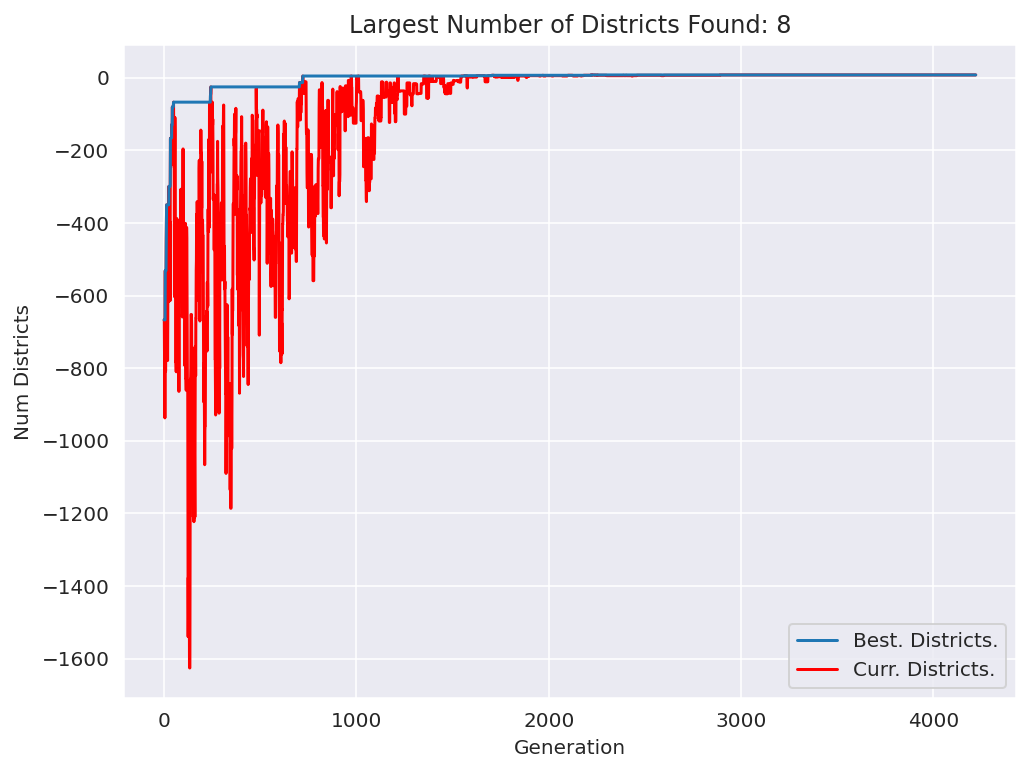

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], -history[:,1], label='Curr. Districts.',color='red')
line_curr, = plt.plot(history[:,0],-history[:,2], label='Best. Districts.')
plt.xlabel('Generation')
plt.ylabel('Num Districts')
plt.legend(handles=[line_curr, line_min])
plt.title('Largest Number of Districts Found: {:d}'.format(int(-best_fitness)));

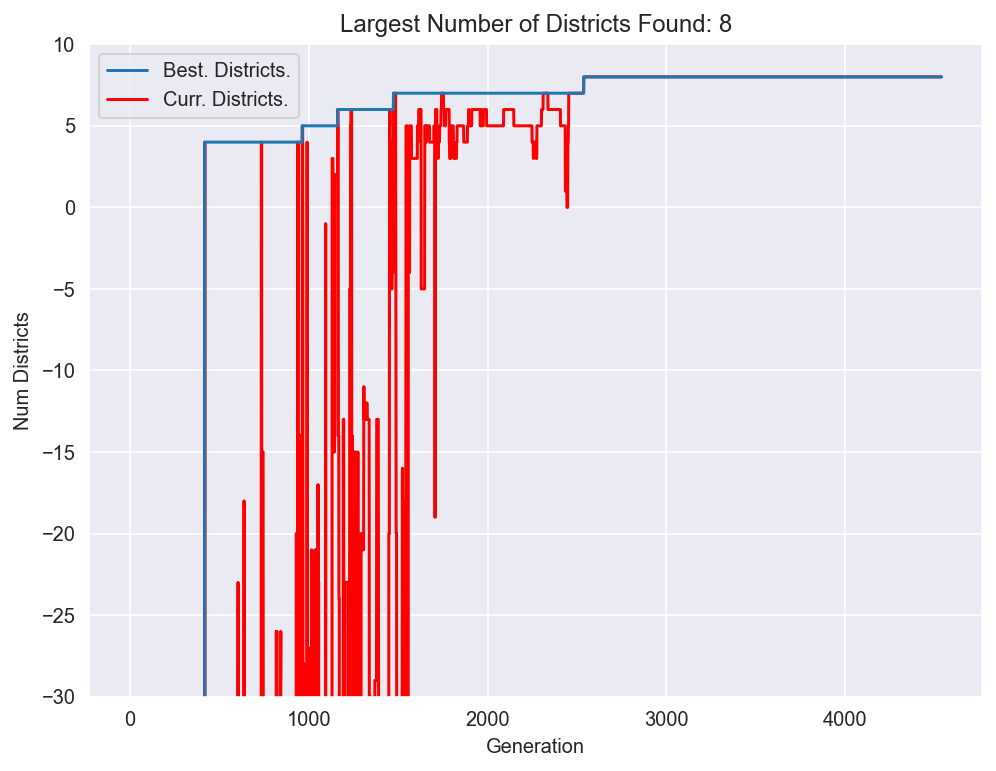

In [43]:
# here is the same graph, but we change the y-axis to -30 to 10 so we can see how the number of districts improves
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

fig = plt.figure(figsize=(8, 6))
line_min, = plt.plot(history[:,0], -history[:,1], label='Curr. Districts.',color='red')
line_curr, = plt.plot(history[:,0],-history[:,2], label='Best. Districts.')
plt.ylim(-30,10)
plt.xlabel('Generation')
plt.ylabel('Num Districts')
plt.legend(handles=[line_curr, line_min])
plt.title('Largest Number of Districts Found: {:d}'.format(int(-best_fitness)));

# *Self Assessment: Simulated Annealing for Gerrymandering with `simanneal`*

In [8]:
# must execute the cell labeled "load problem data and define objective and move functions"
# in the previous self-assessment

from simanneal import Annealer

class GerrymanderingProblem(Annealer):

    # pass extra data (the distance matrix) into the constructor
    def __init__(self, state, cities_df, num_districts):
        self.cities = cities_df
        self.num_dist = num_districts
        super(GerrymanderingProblem, self).__init__(state)  # important!

    def move(self):
        """Move one city to another district"""
        self.state = move_one_city( self.state, self.num_dist)
    
    def energy(self):
        """Compute number of districts - penalty for too small or too large.  Note that 
        the negation is included in the fitness_districts() function"""
        return fitness_districts(self.state, self.cities)

initial_assign = np.random.randint(low=0,high=num_districts,size = num_cities)
gerrymander = GerrymanderingProblem(initial_assign, cities, num_districts)

# the auto schedule takes far longer than .2 minutes, about 100 seconds on CoCalc
gerrymander.set_schedule(gerrymander.auto(minutes=.2)) #set approximate time to find results

# uncomment the following 3 lines to manually control the temperature
# gerrymander.Tmax = 25000.0  # Max (starting) temperature
# gerrymander.Tmin = 2.5      # Min (ending) temperature
# gerrymander.steps = 5000   # Number of iterations

best_assign, best_fitness = gerrymander.anneal()

summarize_districts(best_assign, cities, num_districts)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


,reps,dems,total,rep_win
0,136,112,248,True
1,162,145,307,True
2,154,152,306,True
3,167,160,327,True
4,83,72,155,True
5,167,160,327,True
6,150,138,288,True
7,157,153,310,True
8,62,152,214,False
9,83,75,158,True


When using the manually selected temperature, this usually returns a result of 7 or 8 districts.

Using the auto schedule functionality takes longer but seems to be able to find solutions with 9 districts which is the global maximum.

# *Self-Assessment for Simulated Annealing with Continuous Variables*

In [9]:
# Self-Assessment Solution for Simulated Annealing with Continuous Variables

def f(xy):
    obj = 0.2 + sum(xy**2 - 0.1*np.cos(6*np.pi*xy))
    return obj

def gauss_move(xy,sigma):
    # xy is a 1 by dim numpy array
    # sigma is the standard deviation for the normal distribution
    dim = len(xy)
    return xy + np.random.normal(loc = 0, scale = sigma, size=dim)

def clip_to_bounds(xy,low,high):
    # xy is a 1 by dim numpy array
    # low is the lower bound for clipping variables
    # high is the upper bound for clipping variables
    return np.array( [min(high,max(low,v)) for v in xy])

class NonConvex2D(Annealer):

    # no extra data so just initialize with state
    def __init__(self, state, sigma, low, high):
        self.sigma = sigma
        self.low = low
        self.high = high
        super(NonConvex2D, self).__init__(state)  # important!

    def move(self):
        self.state = gauss_move(self.state, self.sigma)
        self.state = clip_to_bounds(self.state, self.low, self.high)

    def energy(self):
        return f(self.state)

init_state = np.random.uniform(low=-1,high=1,size=2)
sigma = 1/3
low = -1
high = 1

problem2D = NonConvex2D( init_state, sigma, low, high )
problem2D.set_schedule(problem2D.auto(minutes=.2))
best_x, best_fun = problem2D.anneal()

print("Notice that the results below are displayed using scientific notation.\n")
print(f"The lowest function value found by simulated annealing is {best_fun:.3e}")
print(f"That value is achieved when x = {best_x[0]:.3e} and y = {best_x[1]:.3e}")
# refine with local search
from scipy.optimize import minimize

result = minimize(f,best_x)
print("\nAfter refining the result from simulated annealing with local search.")
print(f"The lowest function value found by local search is {result.fun:.3e}")
print(f"That value is achieved when x = {result.x[0]:.3e} and y = {result.x[1]:.3e}")

 Temperature        Energy    Accept   Improve     Elapsed   Remaining


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


Notice that the results below are displayed using scientific notation.

The lowest function value found by simulated annealing is 1.710e-05
That value is achieved when x = 5.372e-04 and y = -7.892e-04

After refining the result from simulated annealing with local search.
The lowest function value found by local search is 1.701e-12
That value is achieved when x = 2.497e-07 and y = 1.682e-07


Notice that we get close to the optimal solution, but only to within 5 or so decimal places.  Simulated annealing is very good at exploring the entire space of solutions but is not so efficient at converging to a nearby minimum value.  Most practical simulated annealing type search algorithms for continuous optimization combine a gradient based local search with the annealing process to promote faster convergence.

# *Self-Assessment:  Genetic Algorithm for the Gerrymandering Problem*

In [13]:
# load the data + random assignment
num_districts = 10
min_voters_in_district = 150
max_voters_in_district = 350

dems = [152,81,75,34,62,38,48,74,98,66,83,86,72,28,112,45,93,72]
reps = [62,59,83,52,87,87,69,49,62,72,75,82,83,53,98,82,68,98]
cities = pd.DataFrame( data = {'dems':dems, 'reps':reps})
num_cities = len(dems)

# uses penalty to 'discourage' out of bounds solutions
def fitness_districts(assign, cities, num_districts):
    df = cities.groupby(assign).sum()
    fitness = sum( df['reps'] > df['dems'] )
    total_voters = np.zeros(num_districts,dtype=np.int32)
    total_voters[df.index] = df.sum(axis=1)
    fitness -= np.abs(np.minimum(np.maximum(total_voters,150),350)-total_voters).sum()
    return (-fitness)

def move_cities(assign,num_districts,ind_prob):
    num_cities = assign.shape[0] # or len(assign)
    new_assign = assign.copy()
    for j in range(num_cities):
        if np.random.uniform() < ind_prob:
            while new_assign[j] == assign[j]: # loops until new and old are different
                new_assign[j] = np.random.randint(num_districts)
    return new_assign

# for printing out an assignment of cities to districts
def summarize_districts(assign, cities, num_districts):
    reps = np.zeros(num_districts, dtype=np.int32)
    dems = np.zeros(num_districts, dtype=np.int32)
    df = cities.groupby(assign).sum()
    reps[df.index] = df['reps']
    dems[df.index] = df['dems']
    total = reps + dems
    delta = np.minimum(np.maximum(total, 150), 350) - total
    rep_win = reps > dems
    dict = {
        'reps': reps,
        'dems': dems,
        'total': total,
        'rep_win': rep_win
    }
    return (pd.DataFrame(data=dict))

In [11]:
pop_size = 20 # should be even due to the way we'll implement crossover
ind_size = num_cities # determines number of input variables for Rastrigin and each individual
# bounds are included in the fitness function so we don't need these
#lower = -5.12 # lower and upper bounds on the real variables
#upper = 5.12
tourn_size = 3 # tournament size for selection
cx_prob = 0.7 # probability a pair of parents crossover to produce two children
mut_prob = 0.3 # probability an individual mutates
ind_prob = 0.1 # probability each variable in an individual mutates
# sigma is only needed for gaussian mutation
#sigma = (upper-lower)/6 # standard deviation (scale) for gaussian mutations
num_iter = 1000 # number of genetic algorithm mutations
update_iter = 100 # how often to display output

stats = np.zeros((num_iter+1,3)) # for collecting statistics

# objective or fitness function

#initialize population and fitness
pop = np.random.randint(low=0, high=num_districts, size = (ind_size,pop_size))
fitness = np.empty(pop_size)
for j in range(pop_size):
    fitness[j] = fitness_districts(pop[:,j],cities,num_districts)
best_fitness = min(fitness)
stats[0,:] = np.array([0,best_fitness, best_fitness])
print('Iteration | Best this iter |    Best ever')

for iter in range(num_iter):
    # tournament selection
    sorted_pos = fitness.argsort() # sort pop by increasing fitness
    fitness = fitness[sorted_pos]
    pop = pop[:,sorted_pos]
    select_pop = np.zeros((ind_size,pop_size)) # initialize selected population
    for j in range(pop_size):
        subset_pos = np.random.choice(pop_size,tourn_size,replace=False) # select without replacement
        smallest_pos = np.min(subset_pos) # choose index corresponding to lowest fitness
        select_pop[:,j] = pop[:,smallest_pos]

    # one-point crossover (mating)
    cx_pop = np.zeros((ind_size,pop_size)) # initialize crossover population
    for j in range(int(pop_size/2)):  # pop_size must be even
        child1 = select_pop[:,2*j] # these are the parents, but we'll swap pieces in place
        child2 = select_pop[:,2*j+1]
        if np.random.uniform() < cx_prob: # crossover occurs
            cx_point = np.random.randint(0,ind_size-1) # crossover point between 0 and ind_size-2
            child1[0:cx_point+1], child2[0:cx_point+1] = child2[0:cx_point+1], child1[0:cx_point+1]
        cx_pop[:,2*j] = child1
        cx_pop[:,2*j+1] = child2

    # mutuation
    mut_pop = cx_pop.copy()
    for j in range(pop_size):
        if np.random.uniform()<mut_prob:
            mut_pop[:,j] = move_cities(mut_pop[:,j], num_districts, ind_prob)

    # fitness evaluation
    pop = mut_pop.copy().astype(int)
    for j in range(pop_size):
        fitness[j] = fitness_districts(pop[:,j],cities,num_districts)

    # collect stats and output to screen
    min_fitness = min(fitness) # best for this iteration
    if min_fitness < best_fitness: # best for all iterations
        best_fitness = min_fitness
        index = np.argmin(fitness)
        best_x = pop[:,index]

    stats[iter+1,:] = np.array([iter+1,min_fitness, best_fitness])
    if (iter+1) % update_iter == 0:
        print(f"{stats[iter+1,0]:9.0f} | {stats[iter+1,1]:14.3e} | {stats[iter+1,2]:12.3e}")
        
print(f"The maximum number of districts won by Republicans is {-best_fitness:.0f}")
print("The location of that maximum  is:")
print('(',', '.join(f"{x:.0f}" for x in best_x),')')

Iteration | Best this iter |    Best ever


      100 |     -6.000e+00 |   -6.000e+00


      200 |     -7.000e+00 |   -7.000e+00


      300 |     -7.000e+00 |   -7.000e+00


      400 |     -7.000e+00 |   -7.000e+00


      500 |     -7.000e+00 |   -7.000e+00


      600 |     -7.000e+00 |   -7.000e+00


      700 |     -7.000e+00 |   -7.000e+00


      800 |     -7.000e+00 |   -7.000e+00


      900 |     -7.000e+00 |   -7.000e+00


     1000 |     -7.000e+00 |   -7.000e+00
The maximum number of districts won by Republicans is 7
The location of that maximum  is:
( 8, 0, 7, 5, 5, 9, 3, 9, 7, 3, 4, 6, 1, 4, 0, 6, 2, 2 )


In [14]:
summarize_districts(best_x,cities,num_districts)

,reps,dems,total,rep_win
0,157,193,350,False
1,83,72,155,True
2,166,165,331,True
3,141,114,255,True
4,128,111,239,True
5,139,96,235,True
6,164,131,295,True
7,145,173,318,False
8,62,152,214,False
9,136,112,248,True
